# Tabular Playground Series - May 2022

The May edition of the 2022 Tabular Playground series binary classification problem that includes a number of different feature interactions. This competition is an opportunity to explore various methods for identifying and exploiting these feature interactions.

- **train.csv - the training data, which includes normalized continuous data and categorical data**
- **test.csv - the test set; your task is to predict binary target variable which represents the state of a manufacturing process.**
- **sample_submission.csv - a sample submission file in the correct format.**

Type: `binary classification`.

Metrics: `area under the ROC curve`.


In [1]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import sys
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

import os
# cwd = os.getcwd()
# cwd = cwd.replace('\\','/')
train = pd.read_csv("C:/Users/misha/Desktop/sample_project_1/tab_May/train.csv")
test = pd.read_csv("C:/Users/misha/Desktop/sample_project_1/tab_May/test.csv")
sub = pd.read_csv("C:/Users/misha/Desktop/sample_project_1/tab_May/sample_submission.csv")

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))
    
df_data = pd.concat([train_d, test])

Train Shape: (900000, 33)
Missing Data: 0
Duplicates: 0

Test Shape: (700000, 32)
Missing Data: 0
Duplicates: 0

No duplicates


In [2]:
int_features = list(df_data.select_dtypes(include='int').columns)
int_features.remove('id')
float_features = list(df_data.select_dtypes(include='float').columns)
object_features = list(df_data.select_dtypes(include='object').columns)
print("int featres:", int_features)
print("float featres:", float_features)
print("object featres:", object_features)

int featres: ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_29', 'f_30']
float featres: ['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_28', 'target']
object featres: ['f_27']


In [3]:
df_data.head(2)

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0.0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1.0


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = [
        'int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64'
    ]
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem))

    return df

# EDA


In [5]:
df_data.dtypes

id          int64
f_00      float64
f_01      float64
f_02      float64
f_03      float64
f_04      float64
f_05      float64
f_06      float64
f_07        int64
f_08        int64
f_09        int64
f_10        int64
f_11        int64
f_12        int64
f_13        int64
f_14        int64
f_15        int64
f_16        int64
f_17        int64
f_18        int64
f_19      float64
f_20      float64
f_21      float64
f_22      float64
f_23      float64
f_24      float64
f_25      float64
f_26      float64
f_27       object
f_28      float64
f_29        int64
f_30        int64
target    float64
dtype: object

In [6]:
train_d.isna().sum().sum()

0

In [7]:
test.isna().sum().sum()

0

In [8]:
df_data.sample(33, axis=1).describe().T.style.bar(
    subset=["mean"], color="#205ff2").background_gradient(
        subset=["std"], cmap="Reds").background_gradient(subset=["50%"],
                                                         cmap="coolwarm")


,count,mean,std,min,25%,50%,75%,max
f_03,1600000.000000,-0.000461,1.000868,-4.658816,-0.675469,-0.001410,0.674252,4.899904
f_14,1600000.000000,1.515139,1.360604,0.000000,0.000000,1.000000,2.000000,14.000000
f_25,1600000.000000,0.175541,2.417219,-13.312784,-1.441875,0.162863,1.795280,12.529179
f_15,1600000.000000,2.100807,1.569054,0.000000,1.000000,2.000000,3.000000,14.000000
id,1600000.000000,799999.500000,461880.359690,0.000000,399999.750000,799999.500000,1199999.250000,1599999.000000
f_18,1600000.000000,2.066436,1.564551,0.000000,1.000000,2.000000,3.000000,13.000000
f_24,1600000.000000,-0.341839,2.387814,-11.838417,-1.953076,-0.340140,1.268113,12.389844
f_13,1600000.000000,2.239231,1.537790,0.000000,1.000000,2.000000,3.000000,13.000000
f_09,1600000.000000,2.361889,1.637264,0.000000,1.000000,2.000000,3.000000,16.000000
f_00,1600000.000000,-0.000199,0.999490,-4.658018,-0.675592,0.000437,0.674935,5.761950


## Target


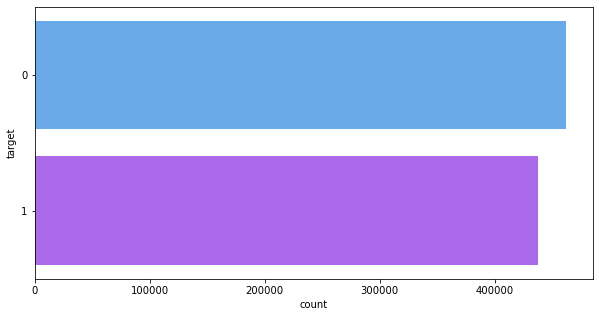

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(y=train_d['target'], palette='cool', orient='h')
plt.show()

# FE


In [10]:
import string

# split label by comma
df_data['new0'] = df_data['f_27'].apply(lambda x: ','.join(x))

# split label by columns
for i in range(10):
    df_data[f'f_27_{i}'] = df_data['new0'].apply(lambda x: x.split(',')[i])

# unique_characters
df_data["unique_characters"] = df_data.f_27.apply(lambda x: len(set(x)))

# drop unnecessary columns
df_data.drop('new0', axis=1, inplace=True)
df_data.drop('f_27', axis=1, inplace=True)
df_data.drop(['id'], axis=1, inplace=True)


# find index of letter in english alphabet
def label_encoding(x):
    return string.ascii_uppercase.index(x)


# encoding
for i in range(10):
    df_data[f'f_27_{i}'] = df_data[f'f_27_{i}'].apply(
        lambda x: label_encoding(x))

# final preprocessing
from sklearn.preprocessing import LabelEncoder

qualitative = [col for col in df_data if df_data[col].dtype == 'object']
for feature in qualitative:
    if feature != "target":
        df_data[feature] = LabelEncoder().fit_transform(df_data[feature])

# memory reduction
df_data = reduce_mem_usage(df_data)

df_train = df_data[df_data.target.isnull() == False]
df_test = df_data[df_data.target.isnull() == True]

df_train['target'] = df_train['target'].astype(int) # !!!!!!!!
df_test = df_test.drop(['target'], axis=1) # !!!!!!!!

X = df_train.drop('target', axis=1)
y = df_train['target']

print(df_train.shape, df_test.shape)

Mem. usage decreased to 154.11 Mb (70.6% reduction)
(900000, 42) (700000, 41)


## Baseline


In [11]:
def baseline(X, y):
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(n_jobs=-1)
    out = cross_val_score(model, X, y, cv=3)
    return out


# train_base = df_data[df_data.target.isnull() == False].copy() #limit rows to reduce time

# train_base.drop('id', axis=1, inplace=True) # remove id
# train_base = reduce_mem_usage(train_base) # memory reduction
# X = train_base.drop('target', axis=1)
# y = train_base['target']

# out = baseline(X,y) # [0.84311667 0.84208667 0.83971667] Mem. usage decreased to 86.69 Mb (70.6% reduction)
# print(out)

## Dimension Reduction Analysis


In [12]:
def plot_pca_target(X, y, features, title, figsize=(16, 8)):
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    pca = PCA(n_components=2)
    X_std = StandardScaler().fit_transform(X[features])
    tr_p = pca.fit_transform(X_std)

    df_pca = pd.DataFrame()
    df_pca['x'] = tr_p[:, 0]
    df_pca['y'] = tr_p[:, 1]
    df_pca['target'] = y

    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=df_pca, x='x', y='y', hue='target', alpha=0.5, s=2)
    ax.set_title(title)
    plt.show()


def plot_pca_traintest(X_train, X_test, features, title, figsize=(16, 8)):
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    pca = PCA(n_components=2)
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train[features])
    X_test_std = scaler.transform(X_test[features])
    tr_p = pca.fit_transform(X_train_std)
    te_p = pca.transform(X_test_std)

    plt.figure(figsize=figsize)
    plt.gca()
    plt.scatter(tr_p[:, 0], tr_p[:, 1], s=1, c='blue',
                label='Train')  # train: blue
    plt.scatter(te_p[:, 0], te_p[:, 1], s=1, c='red',
                label='Test')  # test: yellow
    plt.legend()
    plt.title(title)
    plt.show()

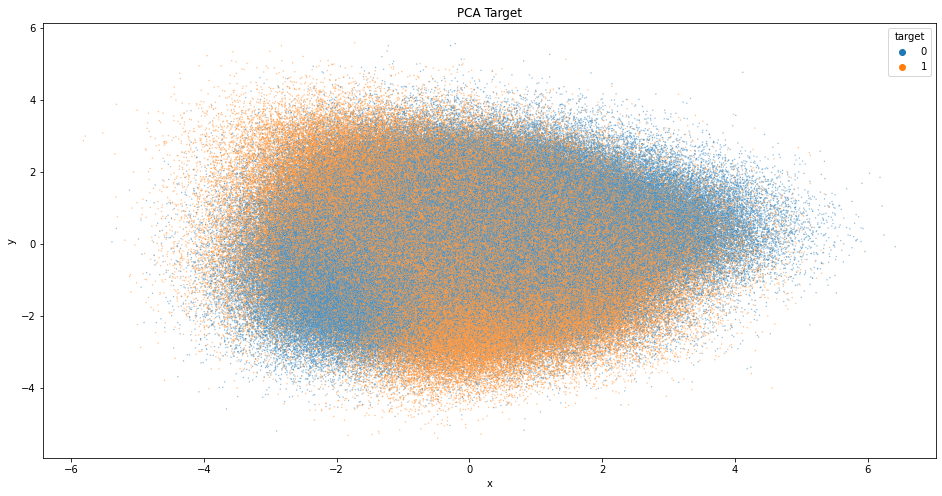

In [13]:
def PCA_target(data):
    features = [col for col in data.columns if col != "id" and col != "target"]
    plot_pca_target(data, data[['target']], features, "PCA Target")
    
PCA_target(df_train)


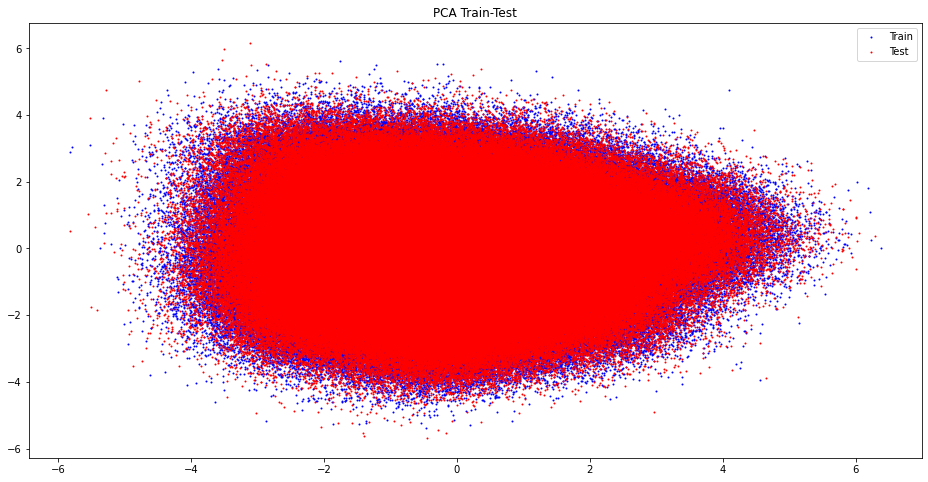

In [14]:
features = [col for col in df_train.columns if col != "id" and col != "target" and col != "f_27"]
plot_pca_traintest(df_train, df_test, features, "PCA Train-Test")

Text(0, 0.5, 'cumulative explained variance')

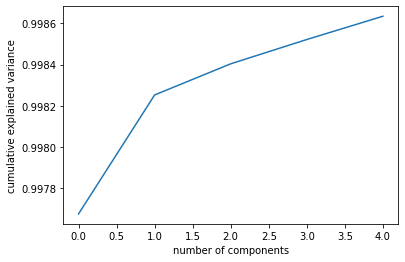

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5).fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


## Mutual Information analysis


In [17]:
def mutual_information():

    # see best parameters by mutial information
    from sklearn.feature_selection import mutual_info_regression
    from sklearn.model_selection import cross_val_score
    from xgboost import XGBRegressor

    def make_mi_scores(X, y):
        X = X.copy()
        for colname in X.select_dtypes(["object"]):
            X[colname], _ = X[colname].factorize()
        # All discrete features should now have integer dtypes
        #discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
        mi_scores = mutual_info_regression(X, y, random_state=0)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        return mi_scores

    y = df_data[df_data['target'].isnull() == False]['target']
    x = df_data[df_data['target'].isnull() == False].drop('target', axis=1)
    mi_scores = make_mi_scores(x, y)
    mi_scores = pd.DataFrame(mi_scores).reset_index().rename(
        columns={'index': 'Feature'})

    fig = px.bar(mi_scores,
                 x='MI Scores',
                 y='Feature',
                 color="MI Scores",
                 color_continuous_scale='darkmint')
    fig.update_layout(height=750,
                      title_text="Mutual Information Scores",
                      title_font=dict(size=29, family="Lato, sans-serif"),
                      xaxis={'categoryorder': 'category ascending'},
                      margin=dict(t=80))


# mutual_information()


In [19]:
def spearman(df_data):
    plt.figure(figsize=(17, 17))
    corr = df_data.corr(method='spearman')
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(30, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(corr,
                    mask=mask,
                    annot=True,
                    cmap="YlGnBu",
                    vmax=.3,
                    center=0,
                    square=True,
                    linewidths=.5,
                    cbar_kws={"shrink": .5})
# spearman(df_train)


# Model


## Pycaret


In [20]:
from pycaret.classification import *

s = setup(data = df_train,
          target = 'target',
          train_size = 0.8,
          fold_strategy = 'stratifiedkfold',
          fold = 2,
          fold_shuffle = True)

,Description,Value
0,session_id,8788
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(900000, 42)"
5,Missing Values,False
6,Numeric Features,41
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [22]:
best_model = compare_models(exclude=['knn']) # best: catboost(AUC=0.9825), xgboost(AUC=0.9725), lightgbm(AUC=0.0.9555)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9358,0.9825,0.9302,0.9374,0.9338,0.8715,0.8715,36.0100
xgboost,Extreme Gradient Boosting,0.9163,0.9725,0.9084,0.9188,0.9135,0.8324,0.8325,36.9450
lightgbm,Light Gradient Boosting Machine,0.8894,0.9555,0.8793,0.8920,0.8856,0.7786,0.7787,8.9100
rf,Random Forest Classifier,0.8693,0.9430,0.8472,0.8797,0.8632,0.7381,0.7386,41.7950
et,Extra Trees Classifier,0.8463,0.9238,0.8162,0.8608,0.8379,0.6920,0.6929,31.0100
qda,Quadratic Discriminant Analysis,0.8316,0.8890,0.8123,0.8370,0.8244,0.6627,0.6630,1.8100
gbc,Gradient Boosting Classifier,0.8275,0.9025,0.7996,0.8386,0.8186,0.6544,0.6551,146.7500
dt,Decision Tree Classifier,0.7572,0.7570,0.7508,0.7505,0.7506,0.5141,0.5141,11.4400
ada,Ada Boost Classifier,0.7200,0.7930,0.6943,0.7203,0.7071,0.4391,0.4393,33.6900
ridge,Ridge Classifier,0.6889,0.0000,0.6653,0.6861,0.6755,0.3769,0.3771,1.7250


## LSTM

- Let us use `Long short-term memory (LSTM)` as we are considering `memory-data`


In [34]:
def Robust_Scaler(df_train, df_test, window):
    from sklearn.preprocessing import RobustScaler

    

    y = df_train['target'].to_numpy().reshape(-1, window)
    df_train = df_train.drop('target', axis=1)
    # standartization
    rb = RobustScaler()
    rb.fit(df_train)

    df_train = rb.transform(df_train)
    df_test = rb.transform(df_test)

    # reshape to get new array
    df_train = df_train.reshape(-1, window, df_train.shape[-1])
    df_test = df_test.reshape(-1, window, df_test.shape[-1])
    # X
    X = df_train

    return X, y

window = 800
X, y = Robust_Scaler(df_train, df_test, window)


In [30]:
def plotHist(hist):
    plt.plot(hist.history["auc"])
    plt.plot(hist.history["val_auc"])
    plt.title("model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

Tensorflow `Bi-LSTM:`


In [31]:
# from tensorflow.distribute import Strategy
def createModel():

    model = Sequential()

    model.add(
        Bidirectional(LSTM(128, return_sequences=True),
                      input_shape=(window, X.shape[-1])))
    model.add(Bidirectional(LSTM(56, return_sequences=True)))
    # model.add(Bidirectional(LSTM(256, return_sequences=True)))
    # model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dense(56, activation='selu')),
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=[AUC(name='auc')])
    return (model)


In [36]:
from sklearn.model_selection import KFold
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping
import gc
from tensorflow.keras.metrics import AUC

kf = KFold(n_splits=5, shuffle=True, random_state=42)

test_preds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"****** fold: {fold+1} *******")
    X_train, X_valid = X[train_idx], X[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]

    es = EarlyStopping(monitor='val_accuracy',
                       mode='max',
                       patience=2,
                       verbose=1,
                       restore_best_weights=True)

    model = createModel()

    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=50,
                        batch_size=128,
                        callbacks=[es])
    test_preds.append(model.predict(df_test).squeeze())
    plotHist(history)
    del X_train, X_valid, y_train, y_valid, model, history
    gc.collect()


****** fold: 1 *******
Epoch 1/50
8/8 [==============================] - 7s 417ms/step - loss: 0.6877 - auc: 0.5577 - val_loss: 0.6743 - val_auc: 0.6234
Epoch 2/50
8/8 [==============================] - 2s 232ms/step - loss: 0.6682 - auc: 0.6287 - val_loss: 0.6590 - val_auc: 0.6506
Epoch 3/50
8/8 [==============================] - 2s 232ms/step - loss: 0.6519 - auc: 0.6629 - val_loss: 0.6386 - val_auc: 0.6889
Epoch 4/50
8/8 [==============================] - 2s 225ms/step - loss: 0.6287 - auc: 0.7041 - val_loss: 0.6082 - val_auc: 0.7318
Epoch 5/50
8/8 [==============================] - 2s 234ms/step - loss: 0.5915 - auc: 0.7507 - val_loss: 0.5732 - val_auc: 0.7756
Epoch 6/50
8/8 [==============================] - 2s 232ms/step - loss: 0.5630 - auc: 0.7804 - val_loss: 0.5466 - val_auc: 0.8026
Epoch 7/50
8/8 [==============================] - 2s 229ms/step - loss: 0.5330 - auc: 0.8106 - val_loss: 0.5166 - val_auc: 0.8245
Epoch 8/50
8/8 [==============================] - 2s 229ms/step - l

KeyboardInterrupt: 

## Catboost

In [28]:
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
import statistics
import datetime

# scores_on_split = []
# for N_SPLITS in range(105,121,5):

N_SPLITS = 10 # 200 is the best score on LB
RANDOM_STATE = 42 


scores = []
y_probs = []
y_probs_final = []

print('Total splits: ', N_SPLITS)
folds = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(folds.split(X, y)):  

    print("fold : ", fold + 1, end = ' ')

    X_train = X.iloc[train_id]
    y_train = y.iloc[train_id]
    X_valid = X.iloc[test_id]
    y_valid = y.iloc[test_id]

#     # def
#     model_def = CatBoostClassifier(verbose=False)
#     model_def.fit(X_train, y_train)
#     valid_pred_def = model.predict(X_valid)
#     valid_score_def = accuracy_score(y_valid, valid_pred_def)
    
    # ensamble
#     model = BaggingClassifier(base_estimator=CatBoostClassifier(verbose=False), random_state=42)

    model = CatBoostClassifier(verbose=False)
    start = datetime.datetime.now()
    model.fit(X_train, y_train)
    end = datetime.datetime.now()

    # validation
    valid_pred = model.predict(X_valid)
    valid_score = accuracy_score(y_valid, valid_pred)
    print( "Validation score: ", np.round(valid_score, 5), 'Time:', end - start)
    scores.append(valid_score)

    # test
    #y_pred = model.predict(df_test)
    y_probs.append(model.predict_proba(df_test))
    print("")
#     scores_on_split.append(statistics.mean(scores))


# scores_on_split

Total splits:  10
fold :  1 Validation score:  0.94021 Time: 0:01:19.192904

fold :  2 

KeyboardInterrupt: 

In [24]:
import statistics
statistics.mean(scores)
# 5: 0.9409311111111112

0.9409311111111112

In [ ]:
# i = np.arange(105,121,5)
# plt.plot(i, scores_on_split)

# Submission


In [26]:
y_probs_final

array([[2.03948224e-02, 9.79605178e-01],
       [1.84549732e-02, 9.81545027e-01],
       [9.99776927e-01, 2.23072879e-04],
       ...,
       [7.23849238e-01, 2.76150762e-01],
       [9.54678908e-01, 4.53210918e-02],
       [9.99996749e-01, 3.25092999e-06]])

In [27]:
y_probs_final = sum(y_probs) / len(y_probs)
y_probs_final

preds = []
for i in y_probs_final:
    if i[0] > i[1]:
        preds.append(0)
    else:
        preds.append(1)
        
def save_submission(y_pred):  
    #classes = label.inverse_transform(y_pred)
    sub["target"] = y_pred
    #assert len(classes) == sub.shape[0]
    assert 2 == sub.shape[1]   
    sub.to_csv("E:/downloads/sample_submission.csv", index=False)
    return sub
save_submission(preds).head(3)


,id,target
0,900000,1
1,900001,1
2,900002,0
